In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%config Completer.use_jedi = False

## Imports

In [2]:
from fastai.vision.all import *
import torch
from pathlib import Path
import gc
from PIL import Image
from fastbook import plot_function
from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle 

D:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\fastbook\__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [3]:
from typing import Tuple

## Get Data

In [4]:
path = untar_data(URLs.MNIST, dest=Path.cwd())

In [5]:
print(path.ls())

[Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/testing'), Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training')]


In [6]:
(path/'training').ls()

(#10) [Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/0'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/1'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/2'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/3'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/4'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/5'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/6'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/7'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_workspace/mnist_png/training/8'),Path('D:/amit/DL_Books/deep_learning_for_coders_with_fastAI/practice_worksp

## Make Dataset

In [7]:
digits_and_labels_train = [(tensor(Image.open(o)), o.parent.name) for p in (path/'training').ls() for o in p.ls()]

In [8]:
pd.DataFrame(digits_and_labels_train[0][0]).style.set_properties(**{'font-size':'9pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,159,253,159,50,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,238,252,252,252,237,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,54,227,253,252,239,233,252,57,6,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,10,60,224,252,253,252,202,84,252,253,122,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,163,252,252,252,253,252,252,96,189,253,167,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,51,238,253,253,190,114,253,228,47,79,255,168,0,0,0,0,0,0


In [9]:
train_x = torch.stack([t for t, l in digits_and_labels_train]).view(-1, 28*28)
train_y = tensor([int(l) for t, l in digits_and_labels_train])
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [10]:
train_x = train_x/255.

In [11]:
digits_and_labels_test = [(tensor(Image.open(o)), o.parent.name) for p in (path/'testing').ls() for o in p.ls()]

In [12]:
test_x = torch.stack([t for t, l in digits_and_labels_test]).view(-1, 28*28)
test_y = tensor([int(l) for t, l in digits_and_labels_test])
test_x.shape, test_y.shape

(torch.Size([10000, 784]), torch.Size([10000]))

In [13]:
test_x = test_x/255.

In [14]:
train_dataset = list(zip(train_x, train_y))
test_dataset = list(zip(test_x, test_y))

## Make DataLoader

In [15]:
train_dl = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=256)

In [16]:
xb, yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256]))

## Create Loss Function

### Cross Entropy Loss

In [18]:
class CrossEntropyC():
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.per_example_loss = []
        
    def compute_loss(self, preds, targets, probs, reduce=torch.mean):
        losses = torch.where(targets==preds, -torch.log(probs-self.epsilon), -torch.log(1-(probs-self.epsilon)))
        self.per_example_loss.extend(list(zip(preds, targets, losses.data)))
        return reduce(losses)

### Test Loss Function

In [17]:
preds = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
targets = tensor([0, 1, 3, 2, 4, 5, 9, 8, 7, 9])
probs = tensor([0.8, 0.7, 0.3, 0.5, 0.6, 0.2, 0.1, 0.9, 0.4, 0.9])
len(preds), len(targets), len(probs)

(10, 10, 10)

In [19]:
loss = CrossEntropyC(epsilon=0.00001)

In [20]:
loss.compute_loss(preds, targets, probs)

tensor(0.6774)

In [21]:
loss.per_example_loss

[(tensor(0), tensor(0), tensor(0.2232)),
 (tensor(1), tensor(1), tensor(0.3567)),
 (tensor(2), tensor(3), tensor(0.3567)),
 (tensor(3), tensor(2), tensor(0.6931)),
 (tensor(4), tensor(4), tensor(0.5108)),
 (tensor(5), tensor(5), tensor(1.6095)),
 (tensor(6), tensor(9), tensor(0.1053)),
 (tensor(7), tensor(8), tensor(2.3025)),
 (tensor(8), tensor(7), tensor(0.5108)),
 (tensor(9), tensor(9), tensor(0.1054))]

## Create Model

### Softmax

In [88]:
def softmax_stable(t): 
    exps = torch.exp(t-t.max(axis=1)[0].view(-1,1))
    return exps/(exps.sum(axis=1).view(-1,1))
    

In [89]:
t = tensor([10.,20.,4.,6,19,16]).view(1,-1)
t

tensor([[10., 20.,  4.,  6., 19., 16.]])

In [90]:
softmax_stable(t)

tensor([[3.2750e-05, 7.2138e-01, 8.1180e-08, 5.9984e-07, 2.6538e-01, 1.3212e-02]])

### Relu

In [47]:
t = tensor([-10., -20.,  4.,  6., 19., 16.])

In [48]:
def relu_c(t): return t.max(tensor(0.0))    

In [49]:
relu_c(t)

tensor([ 0.,  0.,  4.,  6., 19., 16.])

### Simple Net

In [50]:
xb, yb = first(train_dl)

In [51]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

### The Model

In [205]:
class SimpleLinearModel():
    
    def __init__(self, n_layers, n_inputs:Tuple , n_outputs:Tuple, activation_fn=relu_c, output_activation_fn=softmax_stable, pretrained=False, model_filepath=None):
        self.n_layers = n_layers
        self.activation_fn = activation_fn
        self.output_activation_fn = output_activation_fn
        if pretrained and model_filepath:
            self.parameters = self.load_model(model_filepath)
            self.ws = self.parameters[:self.n_layers]
            self.bs = self.parameters[self.n_layers:]
        else:
            self.ws = [self.init_params((i, o)) for i, o in zip(n_inputs, n_outputs)]
            self.bs = [self.init_params(o) for o in n_outputs]
            self.parameters = self.ws + self.bs

    def init_params(self, size, std=1.0):
        return (torch.randn(size)*std).requires_grad_()
    
    def forward(self, xb):
        a = xb
        for n in range(self.n_layers):
            if n == self.n_layers - 1:
                a = self.output_activation_fn(a.mm(self.ws[n]) + self.bs[n])
            else:
                a = self.activation_fn(a.mm(self.ws[n]) + self.bs[n])
        self.probs , self.preds = a.max(axis=1)[0], a.max(axis=1)[1]
        return self.probs , self.preds

    def evaluate(self, yb):
        return sum([p==t for p, t in zip(self.preds, yb)])/len(yb)
    
    def save_model(self, filepath='model.pkl'):
        with open(filepath, 'wb') as f:
            pickle.dump(self.parameters, f)
    
    def load_model(self, filepath):                   
        with open(filepath, 'rb') as f:
                   parameters = pickle.load(f)
        return parameters 
            
    

        

### Test Model

In [92]:
simple_net_c = SimpleLinearModel(2, n_inputs=(28*28, 30), n_outputs=(30, 10))

In [93]:
for p in simple_net_c.parameters:
    print(p.shape)

torch.Size([784, 30])
torch.Size([30, 10])
torch.Size([30])
torch.Size([10])


In [94]:
simple_net_c.ws[0].shape, simple_net_c.ws[1].shape

(torch.Size([784, 30]), torch.Size([30, 10]))

In [95]:
simple_net_c.bs[0].shape, simple_net_c.bs[1].shape

(torch.Size([30]), torch.Size([10]))

In [97]:
probs, preds = simple_net_c.forward(xb)
# a = simple_net_c.forward(xb)

In [98]:
probs, preds

(tensor([0.9971, 0.7198, 0.9972, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9949, 0.7219, 1.0000, 0.9202, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9807, 0.9858,
         1.0000, 1.0000, 0.9044, 1.0000, 1.0000, 0.7179, 0.9552, 1.0000, 0.9992, 0.9710, 1.0000, 1.0000, 0.9774, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9826, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.9820, 0.9992, 0.8965, 0.8529, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8172, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8698, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8426,
         0.9838, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8307, 1.0000, 1.0000, 0.9667, 0.9987, 1.0000, 1.0000, 1.0000, 0.9986, 1.0000, 1.0000, 0.9667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.9926, 0.9754, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9006, 0.9372, 1.0000, 1.0000, 1.0000, 0.9993, 0.5908, 1.0000, 0.9964, 1.0000, 1.0000, 0.9476, 0.9

In [37]:
# w1 = init_params((28*28, 30))
# b1 = init_params(30)
# w2 = init_params((30, 10))
# b2 = init_params(10)

# def simple_net(xb):
#     res = xb.mm(w1)+ b1
#     res = res.max(tensor(0.0))
#     res = res.mm(w2) + b2
#     return softmax_c(res)

# outputs = simple_net(first(train_dl)[0])
# probits = F.softmax(outputs, dim=1)
# probs, preds = probits.max(axis=1)[0], probits.max(axis=1)[1]

In [99]:
loss_fn = CrossEntropyC(epsilon=0.00001)

In [100]:
l = loss_fn.compute_loss(preds, yb, probs)
l

tensor(8.6249, grad_fn=<MeanBackward0>)

In [101]:
l.backward()

In [102]:
simple_net_c.parameters[3].grad

tensor([ 5.7483e-02,  3.3116e-03,  2.2102e-05, -1.8716e-06, -6.7392e-03, -9.6109e-03, -5.7587e-04, -1.6967e-02, -1.6257e-02, -1.0665e-02])

In [103]:
simple_net_c.evaluate(yb)

tensor(0.0664)

In [104]:
loss_fn.per_example_loss[:10]

[(tensor(6), tensor(6), tensor(0.0030)),
 (tensor(0), tensor(6), tensor(1.2724)),
 (tensor(8), tensor(9), tensor(5.8873)),
 (tensor(0), tensor(2), tensor(11.5116)),
 (tensor(0), tensor(3), tensor(11.3677)),
 (tensor(0), tensor(1), tensor(11.5116)),
 (tensor(0), tensor(9), tensor(11.5116)),
 (tensor(0), tensor(7), tensor(11.5116)),
 (tensor(8), tensor(5), tensor(11.5116)),
 (tensor(8), tensor(0), tensor(11.5116))]

## Create Optimizer

In [105]:
class GradientDescentC():
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
        

## Train Loop

In [127]:
def train(model, epochs, optimizer, loss_fn, lr_decay=True):
    metrics = {'epoch': [], 'train_loss': [], 'test_loss': [], 'acc_train': [], 'acc_test': []}
    lr_decay_steps = list(range(0, epochs, 25))
    for i in tqdm(range(epochs)):
        #learning rate decay
        if lr_decay and i in lr_decay_steps[1:]:
            lr = sgd.lr/5
        
        metrics['epoch'].append(i)
        ## train
        acc_trains = []
        acc_tests = []
        train_losses = []
        test_losses = []
        for xb, yb in train_dl:
            probs, preds = model.forward(xb)
            loss = loss_fn.compute_loss(preds, yb, probs)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.data)
            acc_trains.append(model.evaluate(yb))
        train_loss = (sum(train_losses)/len(train_losses)).data.item()
        acc_train = (sum(acc_trains)/len(acc_trains)).data.item()
        
        metrics['train_loss'].append(train_loss)
        metrics['acc_train'].append(acc_train)
        
        ## validate 
        for xb, yb in test_dl:
            probs, preds = model.forward(xb)
            acc_tests.append(model.evaluate(yb))
            test_losses.append(loss_fn.compute_loss(preds, yb, probs))
        test_loss = (sum(test_losses)/len(test_losses)).data.item()
        acc_test = (sum(acc_tests)/len(acc_tests)).data.item()
        
#         print(pd.DataFrame({'train_loss':train_loss.data.item(), 'train_acc':acc_train.data.item(), 'test_acc':acc_test.data.item()}))
        metrics['test_loss'].append(test_loss)
        metrics['acc_test'].append(acc_test)
        
        if i >0 and (i%5==0 or (i ==epochs-1)) :
            print({'epoch': i, 'train_loss':train_loss, 'test_loss':test_loss, 'train_acc':acc_train, 'test_acc':acc_test})
    return metrics
        

### Training without Learning Decay

In [115]:
model = SimpleLinearModel(3, n_inputs=(28*28, 50, 25), n_outputs=(50, 25, 10))
loss_fn = CrossEntropyC(epsilon=0.00001)
sgd = GradientDescentC(model.parameters, lr=0.1)

In [116]:
metrics = train(model, 100, optimizer=sgd, loss_fn=loss_fn, lr_decay=False)

  0%|          | 0/100 [00:00<?, ?it/s]

{'epoch': 5, 'train_loss': 0.43648073077201843, 'test_loss': 0.448186457157135, 'train_acc': 0.3688054084777832, 'test_acc': 0.38505858182907104}
{'epoch': 10, 'train_loss': 0.4350285232067108, 'test_loss': 0.45321446657180786, 'train_acc': 0.4825742244720459, 'test_acc': 0.4849609434604645}
{'epoch': 15, 'train_loss': 0.4148310124874115, 'test_loss': 0.43377742171287537, 'train_acc': 0.5471853017807007, 'test_acc': 0.542187511920929}
{'epoch': 20, 'train_loss': 0.3774803578853607, 'test_loss': 0.3889409899711609, 'train_acc': 0.6239306330680847, 'test_acc': 0.6171875}
{'epoch': 25, 'train_loss': 0.30884575843811035, 'test_loss': 0.3029526472091675, 'train_acc': 0.6524600982666016, 'test_acc': 0.6314452886581421}
{'epoch': 30, 'train_loss': 0.27625390887260437, 'test_loss': 0.29117637872695923, 'train_acc': 0.6734486222267151, 'test_acc': 0.66748046875}
{'epoch': 35, 'train_loss': 0.2556435763835907, 'test_loss': 0.28990763425827026, 'train_acc': 0.6864638924598694, 'test_acc': 0.67910

### Training with Learning Rate Decay

In [128]:
model = SimpleLinearModel(3, n_inputs=(28*28, 50, 25), n_outputs=(50, 25, 10))
loss_fn = CrossEntropyC(epsilon=0.00001)
sgd = GradientDescentC(model.parameters, lr=0.1)

In [129]:
metrics = train(model, 100, optimizer=sgd, loss_fn=loss_fn, lr_decay=True)

  0%|          | 0/100 [00:00<?, ?it/s]

{'epoch': 5, 'train_loss': 1.5392154455184937, 'test_loss': 1.418341875076294, 'train_acc': 0.854687511920929, 'test_acc': 0.8651367425918579}
{'epoch': 10, 'train_loss': 1.1419862508773804, 'test_loss': 1.190634846687317, 'train_acc': 0.8919603228569031, 'test_acc': 0.8827148675918579}
{'epoch': 15, 'train_loss': 0.9906216263771057, 'test_loss': 0.9536762237548828, 'train_acc': 0.9052526354789734, 'test_acc': 0.90869140625}
{'epoch': 20, 'train_loss': 0.8637762665748596, 'test_loss': 0.9215826988220215, 'train_acc': 0.9172927737236023, 'test_acc': 0.9122070074081421}
{'epoch': 25, 'train_loss': 0.7844356298446655, 'test_loss': 0.8514246940612793, 'train_acc': 0.9249556660652161, 'test_acc': 0.918749988079071}
{'epoch': 30, 'train_loss': 0.7467063069343567, 'test_loss': 0.8274339437484741, 'train_acc': 0.9283466339111328, 'test_acc': 0.9198242425918579}
{'epoch': 35, 'train_loss': 0.6918111443519592, 'test_loss': 0.7018330693244934, 'train_acc': 0.9330341219902039, 'test_acc': 0.932714

### Save Trained Model

In [208]:
model.save_model(filepath='models/mnist_simple_linear_model.pkl')

### Load Model

In [209]:
model = SimpleLinearModel(3, n_inputs=(28*28, 50, 25), n_outputs=(50, 25, 10), pretrained=True, model_filepath='models/mnist_simple_linear_model.pkl')

In [211]:
# [x==y for x,y in zip(model.parameters, parameters)]

## Predict

In [212]:
_, preds = model.forward(xb)

In [213]:
preds

tensor([6, 6, 9, 2, 3, 1, 9, 7, 5, 0, 4, 0, 4, 9, 8, 0, 4, 8, 2, 7, 1, 3, 2, 8, 3, 1, 4, 5, 6, 6, 6, 8, 5, 1, 3, 1, 7, 7, 0, 7, 9, 0, 9, 7, 9, 6, 2, 4, 1, 9, 2, 9, 5, 5, 1, 2, 5, 0, 8, 5, 6, 3, 6, 6,
        1, 2, 0, 6, 5, 0, 2, 9, 1, 9, 8, 5, 0, 9, 0, 9, 1, 2, 4, 2, 2, 0, 3, 9, 7, 3, 2, 4, 3, 0, 6, 2, 0, 7, 6, 0, 0, 5, 0, 7, 0, 2, 3, 1, 7, 8, 1, 5, 7, 6, 6, 4, 1, 9, 5, 9, 4, 3, 0, 9, 2, 7, 8, 3,
        2, 5, 8, 5, 0, 7, 0, 8, 8, 1, 0, 6, 2, 3, 9, 9, 4, 5, 8, 4, 2, 3, 0, 7, 7, 3, 7, 3, 2, 7, 3, 3, 4, 6, 7, 9, 9, 2, 2, 4, 4, 3, 7, 9, 5, 4, 7, 7, 1, 0, 8, 2, 5, 0, 8, 6, 6, 5, 1, 6, 3, 8, 6, 1,
        2, 7, 5, 8, 0, 8, 1, 8, 3, 9, 4, 9, 7, 4, 2, 7, 3, 5, 8, 4, 4, 4, 8, 3, 0, 1, 0, 8, 8, 6, 4, 7, 0, 8, 4, 3, 9, 7, 2, 4, 0, 7, 7, 8, 0, 9, 7, 1, 8, 0, 7, 5, 6, 5, 7, 5, 0, 2, 1, 7, 1, 3, 8, 5])

In [214]:
model.evaluate(yb)

tensor(0.9883)

## Evaluate

In [141]:
metrics = pd.DataFrame.from_dict(metrics, orient='index').transpose()

In [166]:
metrics.sample(10)

,epoch,train_loss,test_loss,acc_train,acc_test
83,83.0,0.440607,0.561062,0.956799,0.944922
53,53.0,0.557946,0.632479,0.945329,0.938477
70,70.0,0.491314,0.820845,0.951812,0.919922
45,45.0,0.618021,0.677207,0.940088,0.933496
44,44.0,0.626953,0.724009,0.939617,0.929395
39,39.0,0.663377,0.742327,0.935683,0.928613
22,22.0,0.824504,0.929128,0.921000,0.911816
80,80.0,0.452223,0.562958,0.955441,0.945605
10,10.0,1.141986,1.190635,0.891960,0.882715
0,0.0,7.067844,4.834762,0.348609,0.542285


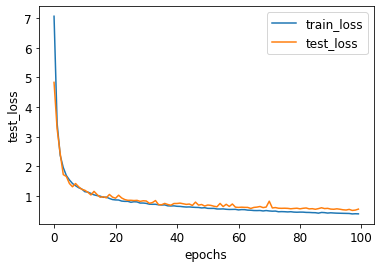

In [164]:
metrics.train_loss.plot(xlabel='epochs', ylabel='train_loss', legend='train_loss')
metrics.test_loss.plot(xlabel='epochs', ylabel='test_loss', legend='test_loss');

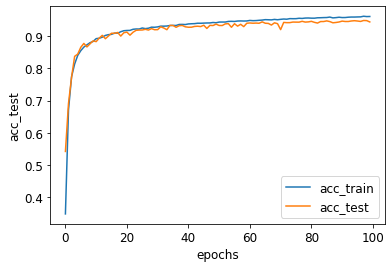

In [165]:
metrics.acc_train.plot(xlabel='epochs', ylabel='acc_train', legend='acc_train');
metrics.acc_test.plot(xlabel='epochs', ylabel='acc_test', legend='acc_test');

## Compare Results with FastAI Learner

In [143]:
dls = DataLoaders(train_dl, test_dl)

In [144]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 10)
)

In [145]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [146]:
learn.fit(20, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.516670,0.391799,0.889400,00:02
1,0.333141,0.308881,0.907600,00:01
2,0.278659,0.260834,0.924700,00:01
3,0.246330,0.253079,0.922700,00:01
4,0.213505,0.212498,0.937700,00:01
5,0.198868,0.194417,0.943100,00:01
6,0.181147,0.172466,0.948200,00:01
7,0.162241,0.169970,0.949900,00:01
8,0.151031,0.156515,0.951300,00:01
9,0.136207,0.144687,0.957500,00:01


In [160]:
learn.recorder.values[0]

(#3) [0.5166699290275574,0.39179864525794983,0.8894000053405762]

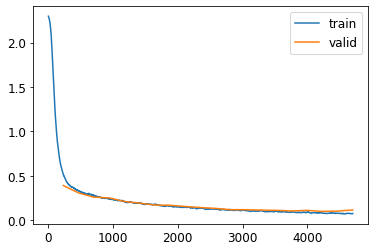

In [161]:
learn.recorder.plot_loss()